# Skorch 기반의 Custom Loss 정의
- Loss항에 Custom parameter 추가 시 수렴 확인
- [Ref] https://skorch.readthedocs.io/en/latest/user/customization.html

In [1]:
import math
import time
import os
import numpy as np
import pdb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset

import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pickle
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, Callback
from skorch.helper import predefined_split

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.set_device(0)
torch.manual_seed(20201130)
torch.cuda.manual_seed(20201130)

### Data load

In [4]:
data_files = ['g:/nox/data/busan_5gt_nox7_72_23.npy']

In [5]:
class NOxDataBase(Dataset):
    # 미리 설정된 특징의 최대/최소 값
    user_maximum = [10, 40, 12, 10, 100, 500, 1100, 200, 25, 200, 10, 25, 350, 200, 7000, 700, 350, 200, 120000, 100, 100, 100, 10]
    user_minimum = [ 0,-10,  0,  6,   0,   0,    0,   0,  0,   0,  0,  0, 100,   0, 2000,   0, 100,   0,      0,   0,   0,   0,  0]

    data_loaded = False
    train_x, train_y, valid_x, valid_y = None, None, None, None
    maximum, minimum = None, None

    def __init__(self, data_name):
        if not NOxDataBase.data_loaded:
            self._load_data(data_name)
            self._normalize()
            NOxDataBase.data_loaded = True  # 데이터 로딩 완료
            print(self.train_x.shape, self.train_y.shape)
            print(self.valid_x.shape, self.valid_y.shape)
        else:
            print("⚡ 데이터 이미 로드됨. 기존 데이터 사용!")

    def _load_data(self, data_name):
        print("📂 데이터 로딩 중...")
        NOxDataBase.data_dict = [np.load(in_data, allow_pickle='TRUE').item() for in_data in data_name]
        NOxDataBase.train_x = np.concatenate([a1['train_x'] for a1 in NOxDataBase.data_dict], axis=0)
        NOxDataBase.train_y = np.concatenate([a1['train_y'] for a1 in NOxDataBase.data_dict], axis=0)
        NOxDataBase.valid_x = np.concatenate([a1['valid_x'] for a1 in NOxDataBase.data_dict], axis=0)
        NOxDataBase.valid_y = np.concatenate([a1['valid_y'] for a1 in NOxDataBase.data_dict], axis=0)
        NOxDataBase.maximum = np.ones(NOxDataBase.train_x.shape[2])
        NOxDataBase.minimum = np.ones(NOxDataBase.train_x.shape[2])

    def _normalize(self):
        print("🔄 데이터 정규화 중...")
        NOxDataBase.maximum = self.user_maximum
        NOxDataBase.minimum = self.user_minimum
        for v in range(NOxDataBase.train_x.shape[2]):
            denom = NOxDataBase.maximum[v] - NOxDataBase.minimum[v]
            NOxDataBase.train_x[:, :, v] = np.clip((NOxDataBase.train_x[:, :, v] - NOxDataBase.minimum[v]) / denom, 0.0, 1.0)
            NOxDataBase.train_y[:, :, v] = np.clip((NOxDataBase.train_y[:, :, v] - NOxDataBase.minimum[v]) / denom, 0.0, 1.0)
            NOxDataBase.valid_x[:, :, v] = np.clip((NOxDataBase.valid_x[:, :, v] - NOxDataBase.minimum[v]) / denom, 0.0, 1.0)
            NOxDataBase.valid_y[:, :, v] = np.clip((NOxDataBase.valid_y[:, :, v] - NOxDataBase.minimum[v]) / denom, 0.0, 1.0)

        print('✅ Max value of features = {}'.format(NOxDataBase.maximum))
        print('✅ Min value of features = {}'.format(NOxDataBase.minimum))

class NOxTrain(NOxDataBase):
    def __len__(self):
        return len(NOxDataBase.train_x)

    def __getitem__(self, idx):
        return NOxDataBase.train_x[idx], NOxDataBase.train_y[idx, 0, :]

class NOxValid(NOxDataBase):
    def __len__(self):
        return len(NOxDataBase.valid_x)

    def __getitem__(self, idx):
        return NOxDataBase.valid_x[idx], NOxDataBase.valid_y[idx, 0, :]

# 데이터셋 객체 생성
train_data = NOxTrain(data_files)
print('------------------------------')
valid_data = NOxValid(data_files)
print('------------------------------')

print(valid_data.data_dict[0].keys())
print(valid_data.data_dict[0]['features'])
valid_data.data_dict[0]['tic'], valid_data.data_dict[0]['Data_date']

📂 데이터 로딩 중...
🔄 데이터 정규화 중...
✅ Max value of features = [10, 40, 12, 10, 100, 500, 1100, 200, 25, 200, 10, 25, 350, 200, 7000, 700, 350, 200, 120000, 100, 100, 100, 10]
✅ Min value of features = [0, -10, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 2000, 0, 100, 0, 0, 0, 0, 0, 0]
(362780, 72, 23) (362780, 16, 23)
(123420, 72, 23) (123420, 16, 23)
------------------------------
⚡ 데이터 이미 로드됨. 기존 데이터 사용!
------------------------------
dict_keys(['train_x', 'train_y', 'valid_x', 'valid_y', 'File', 'Date', 'tic', 'ID', 'loc', 'Data_date', 'cut_len', 'features'])
Fuel(0),Embient Temp(1),암모니아수Line압력(2),무화용압축공기압력(3),탈질환원제밸브개도율(4),1stMetal온도(5),Amm Flow(6),InletNox(7),InletO2(8),OutletNOx(9),OutletNH3(10),OutletO2(11),SCROutletTemp(12),MW(13),AmmTankLevel(14),배기가스온도(15),SCR후단온도(16),STMW(17),GT배기량(18),SCRInletNO(19),SCRInletNO2(20),shiftedTMSNox(21),shiftedNH3Slip(22)


('5sec', '241202+250113')

### 필요 데이터 추출

In [6]:
def model_data(inputs):
    x0 = []
    y0 = []
    # 12와 16은 동일함(태그가 동일)
    indx = [0,1,5,6,7,8,11,13,15,16,18]
    for aa in inputs:  # aa[0]=(32, 21), aa[1]=(21,)
        #bb = aa[0].copy()
        #bb[:,7] = np.roll(aa[0][:,7],shift=-69)  # Inlet NOx: 50
        #bb[:,9] = np.roll(aa[0][:,9],shift=-69)  # Outlet NOx
        #x0.append(bb[2,indx])
        #y0.append(bb[2,[9,21]])
        x0.append(aa[0][-32:,indx])   
        y0.append(aa[1][21:22])  

    x0 = np.array(x0, dtype=np.float32)
    y0 = np.array(y0, dtype=np.float32)
    return x0, y0


train_x0, train_y0 = model_data(train_data)
valid_x0, valid_y0 = model_data(valid_data)
train_x0.shape, train_y0.shape, valid_x0.shape, valid_y0.shape, 

((362780, 32, 11), (362780, 1), (123420, 32, 11), (123420, 1))

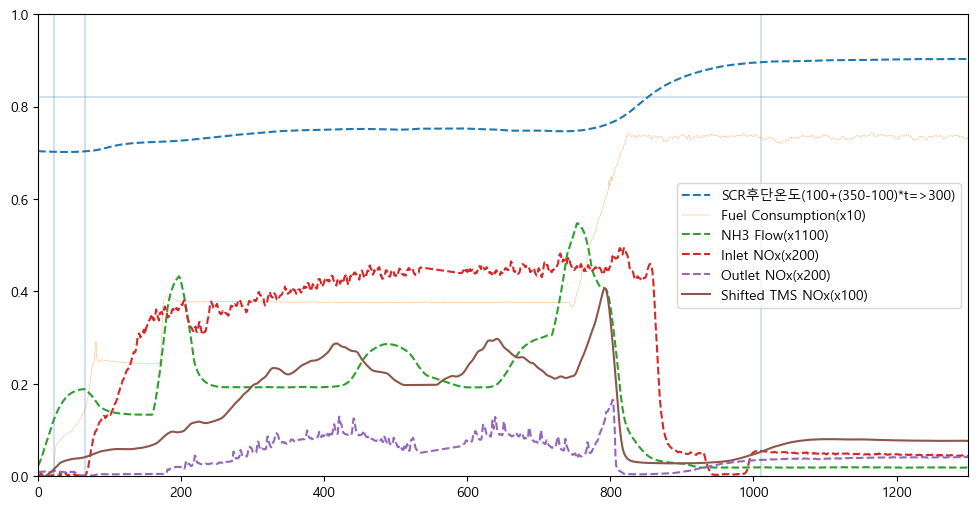

In [58]:
# 지연안된 원본 데이터의 디스플레이 (!!!!!엔터치지 말것)

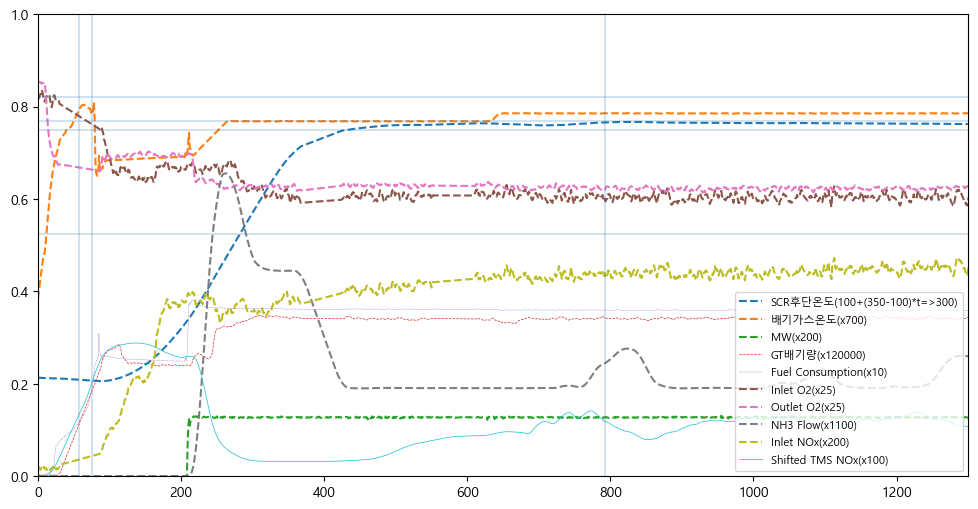

In [50]:
i = 14 # 14(초기 NOx과다)
st, et = 1870*i, (i+1)*1870

plt.figure(figsize=(12,6))
plt.ylim(0,1)
plt.xlim(0,1300)
plt.plot(train_x0[st:et,-1,9],'--', label='SCR후단온도(100+(350-100)*t=>300)')  
plt.plot(train_x0[st:et,-1,8],'--', label='배기가스온도(x700)')  
plt.plot(train_x0[st:et,-1,7],'--', label='MW(x200)')  
plt.plot(train_x0[st:et,-1,10],'--', linewidth=0.5, label='GT배기량(x120000)')  
plt.plot(train_x0[st:et,-1,0],'--', linewidth=0.3, label='Fuel Consumption(x10)')  
plt.plot(train_x0[st:et,-1,5],'--', label='Inlet O2(x25)')  
plt.plot(train_x0[st:et,-1,6],'--', label='Outlet O2(x25)')  
plt.plot(train_x0[st:et,-1,3],'--', label='NH3 Flow(x1100)')
plt.plot(train_x0[st:et,-1,4],'--', label='Inlet NOx(x200)')
#plt.plot(train_y0[st:et,0],'--', label='Outlet NOx(x200)')
plt.plot(0.5*train_y0[st:et,0], linewidth=0.5, label='Shifted TMS NOx(x100)')
plt.axhline(y=0.82, linewidth=0.3)
plt.axhline(y=0.77, linewidth=0.3)
plt.axhline(y=0.75, linewidth=0.3)
plt.axhline(y=0.525, linewidth=0.3)
plt.axvline(x=76, linewidth=0.3)
plt.axvline(x=57, linewidth=0.3)
plt.axvline(x=793, linewidth=0.3)
plt.legend(fontsize=8, loc="lower right")
plt.show()

In [248]:
# (1) scr후단 온도
tt = np.array([0.7,0.75,0.77,0.78,0.8,0.9])
ff = 1/(1+np.exp(-20*(tt-0.77)))
# ff=[0.19781611, 0.40131234, 0.5, 0.549834, 0.64565631,0.93086158]

# (2) 몰비: torch.min((NH3 / (NOx_in + 1e-6)), torch.tensor(1.0, device=NOx_in.device)) ** self.beta
nh3 = np.array([0.2, 0.32, 0.35, 0.3, 0.5, 0.6])
nox_in = np.array([0.25, 0.4, 0.43, 0.42, 0.45, 0.5])
vv1 = np.minimum(nh3/(nox_in+1e-6),1)
# vv=[0.8 , 0.78  , 0.814 , 0.714, 1., 1.]

# (3) 산소소비: torch.exp(-self.alpha * (O_out - self.O_opt) ** 2) 
o2 = np.array([0.85, 0.68, 0.62, 0.55, 0.525,0.525])
vv2 = np.exp(-10*(o2-0.525)*(o2-0.525))
# vv = [0.35, 0.79, 0.91, 0.99, 1., 1.0]

# (4) All product
nox_out = nox_in * (1-ff*vv1*vv2)
nox_out

array([0.23624165, 0.29900679, 0.27010239, 0.25607791, 0.15945466,
       0.03456921])

### DNN 모델

In [7]:
class NOxPred(nn.Module):
    def __init__(self, tlen=32):
        super(NOxPred, self).__init__()
        self.gru1 = nn.GRU(11,64,1,batch_first=True)
        self.fc1 = nn.Linear(2048,512)  # 2048=64*32   
        self.fc2 = nn.Linear(512,128)   
        self.fc3 = nn.Linear(128,1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x1):
        r1 = torch.randn(1,x1.shape[0], 64).cuda()  # (1,b,64)
        t1, _ = self.gru1(x1, r1)  # (b,32,64)
        # pdb.set_trace()
        o1 = self.fc1(t1.reshape(t1.shape[0],-1))  # (b,2048)->(b,512)
        o2 = self.fc2(F.softplus(self.dropout1(o1)))
        o3 = self.fc3(F.softplus(self.dropout2(o2)))
        return o3  # (b,21)
    
    
model = NOxPred()

In [8]:
class CustomNet(NeuralNetRegressor):
    def initialize_module(self):
        super().initialize_module()

        self.k = nn.Parameter(torch.tensor(0.0, dtype=torch.float32, device=self.device))  
        # self.Tc = torch.tensor(0.77, device=self.device)
        return self

    def initialize_optimizer(self):
        super().initialize_optimizer()

        named_params = list(self.module_.named_parameters())  
        # extra_params = [("k", self.k), ("alpha", self.alpha), ("beta", self.beta)] 
        extra_params = [("k", self.k)] 
        named_params.extend(extra_params)  # 기존 파라미터 리스트에 추가

        args, kwargs = self.get_params_for_optimizer("optimizer", named_params)
        self.optimizer_ = self.optimizer(*args, **kwargs)
        return self

    def train_step_single(self, batch, **fit_params):
        Xi, yi = batch
        # Xi, yi, extra_input = batch
        self._set_training(True)

        # pdb.set_trace()
        y_pred = self.infer(Xi, **fit_params)
        if self.device != yi.device:
            Xi = Xi.to(self.device)
            yi = yi.to(self.device)
            # extra_input = extra_input.to(self.device)

        # ✅ 학습 가능한 변수 가져오기
        k = self.k

        # ✅ 학습 가능한 변수 제한
        # with torch.no_grad():
        #     self.k.clamp_(0.1, 10.0)

        # 🚀 k초기치=0 -> k=1로 수렴함을 확인하였음: Custom param도 수렴 증명
        loss = torch.mean((yi - y_pred) ** 2) + 1 - torch.exp(-(k-1)**2)
        # print(k)

        # ✅ 물리 제약 손실 (SCR 후단 NOx 변환 예측): 잘 안됨
        # eta_T = 1 / (1 + torch.exp(-torch.clamp(k * (T - self.Tc), -10, 10)))  
        # eta_NH3 = eta_T * torch.clamp((NH3 / (beta*NOx_in + 1e-6)) , min=1e-6, max=1.0)
        # eta_O2 = eta_NH3 * torch.exp(-torch.clamp(alpha * (O_out - self.O_opt)**2, -10, 10))  
        # NOx_out_phys = NOx_in * (1 - eta_O2)
        # loss_phys = torch.mean((y_pred - NOx_out_phys) ** 2)
        # loss = loss_data + 0.2 * loss_phys
        # ✅ NaN 발생 여부 확인
        # if torch.isnan(loss):
        #     print("⚠️ Warning: NaN detected in loss!")
        #     loss = torch.tensor(0.0, device=loss.device)  

        loss.backward()
        return {'loss': loss, 'y_pred': y_pred}    

    def validation_step(self, batch, **fit_params):
        X, y, extra_input = batch
        with torch.no_grad():
            y_pred = self.forward(X)
        loss = torch.mean((y - y_pred) ** 2)  # 검증 시 MSE 손실 사용
        return {"loss": loss, "y_pred": y_pred}

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y, extra_input):
        self.X = X
        self.y = y
        self.extra_input = extra_input

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] #, self.extra_input[idx]  # 추가 입력 반환


train_dataset = CustomDataset(train_x0, train_y0[:,0], train_x0)
# valid_dataset = CustomDataset(X_train, y_train, extra_input_values)

In [10]:
net =  CustomNet(  #NeuralNetRegressor(  #
    module = model,
    optimizer=torch.optim.Adam,
    max_epochs=20,
    batch_size=2048,
    train_split=predefined_split(None),  # ✅ 검증 데이터 사용 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

# 모델 학습
net.fit(train_dataset, y=None)

  epoch    train_loss     dur
-------  ------------  ------
      1        4.5806  2.5692
      2        0.0142  2.4281
      3        0.0124  2.4574
      4        0.0115  2.4453
      5        0.0111  2.4925
      6        0.0107  2.4650
      7        0.0105  2.4229
      8        0.0102  2.4131
      9        0.0100  2.4208
     10        0.0098  2.3995


<class '__main__.CustomNet'>[initialized](
  module_=NOxPred(
    (gru1): GRU(11, 64, batch_first=True)
    (fc1): Linear(in_features=2048, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  ),
)